In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.cluster import k_means
from sklearn.mixture import GMM
plt.rcParams['figure.figsize'] = (10.0, 8.0)

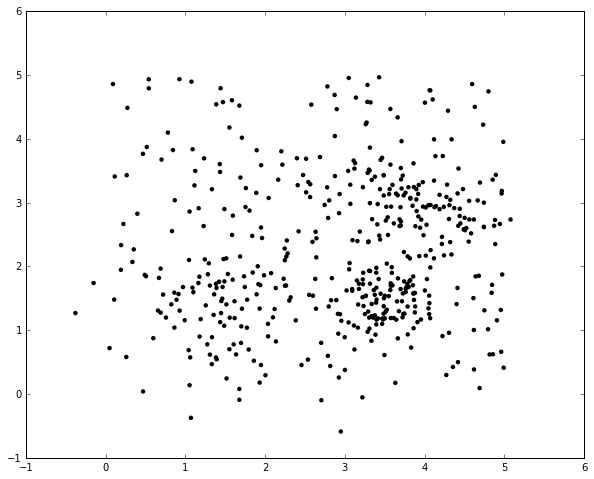

In [3]:
# generate random data
np.random.seed(3)
x1 = np.random.normal(loc=4.0, scale=0.5, size=100)
y1 = np.random.normal(loc=3.0, scale=0.5, size=100)
l1 = [1 for i in x1]
x2 = np.random.normal(loc=1.5, scale=0.7, size=100)
y2 = np.random.normal(loc=1.5, scale=0.7, size=100)
l2 = [2 for i in x2]
x3 = np.random.normal(loc=3.5, scale=0.3, size=100)
y3 = np.random.normal(loc=1.5, scale=0.3, size=100)
l3 = [3 for i in x3]
xb = np.random.uniform(low=0, high=5, size=200)
yb = np.random.uniform(low=0, high=5, size=200)
lb = [4 for i in xb]

# put data into single array
xs = np.hstack((x1, x2, x3, xb))
ys = np.hstack((y1, y2, y3, yb))
ls = np.hstack((l1, l2, l3, lb))

# calculate total sum of squares from mean value        
tss = np.sum((xs-xs.mean())**2 + (ys-ys.mean())**2)

# put data into single 2D array
X = np.array(zip(xs,ys))
plt.scatter(xs,ys, c='black', edgecolors='none')

In [4]:
k_vals = range(1,11)
wss_vals = []
ch_vals = []

for k in k_vals:
    centers, labels, wss = k_means(X, n_clusters=k)
    ch = ((tss-wss)/(k-1))/(wss/(X.size-k))
    wss_vals.append(wss)
    ch_vals.append(ch)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in double_scalars


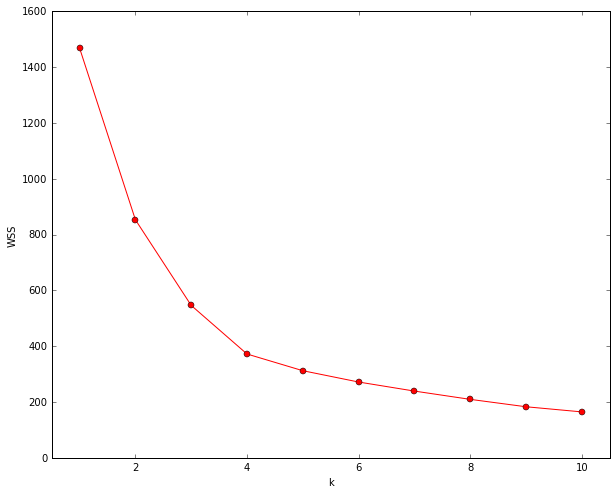

In [5]:
plt.plot(k_vals, wss_vals, 'ro-')
plt.xlim(0.5,10.5)
plt.xlabel('k')
plt.ylabel('WSS')

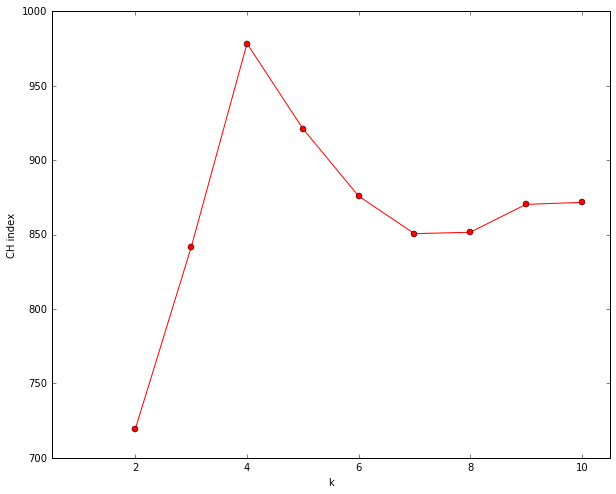

In [6]:
plt.plot(k_vals, ch_vals, 'ro-')
plt.xlim(0.5,10.5)
plt.xlabel('k')
plt.ylabel('CH index')

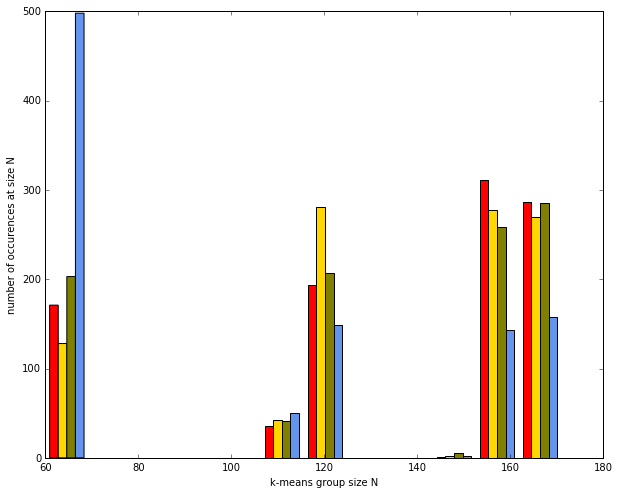

In [9]:
# stability of clusters
# run k means 1000 times and keep track of cluster sizes
nums = []
for i in range(1000):
    centers, labels, wss = k_means(X, n_clusters=4)
    h, b = np.histogram(labels, bins=4, range=[-0.5,3.5])
    nums.append(h)
    
nums = np.array(nums)
plt.clf()
plt.hist((nums[:,0],nums[:,1],nums[:,2],nums[:,3]), bins=12, histtype='bar', color=['red', 'gold', 'olive', 'cornflowerblue'])
plt.xlabel('k-means group size N')
plt.ylabel('number of occurences at size N')

In [8]:
centers, labels, wss = k_means(X, n_clusters=4)

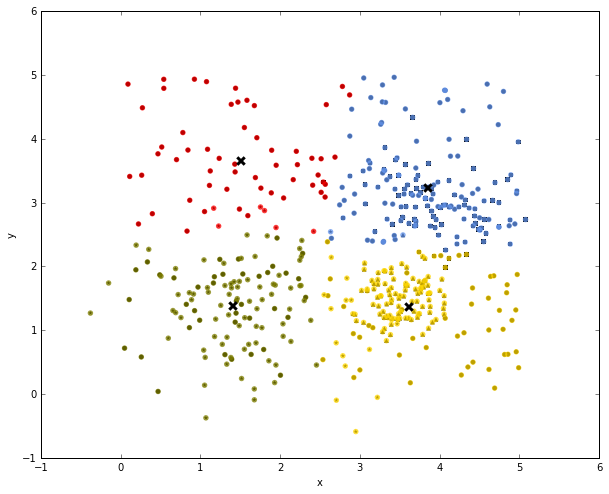

In [10]:
cmap = colors.ListedColormap(['red', 'gold', 'olive', 'cornflowerblue'], N=4)
plt.scatter(x1, y1, c='black', marker='s', edgecolors='none')
plt.scatter(x2, y2, c='black', marker='*', edgecolors='none')
plt.scatter(x3, y3, c='black', marker='^', edgecolors='none')
plt.scatter(xb, yb, c='black', marker='o', edgecolors='none')
plt.scatter(xs, ys, c=labels, cmap=cmap, s=30, marker='o', edgecolors='none', alpha=0.75)
plt.scatter(centers[:,0], centers[:,1], c='black', s=55, marker='x', lw=3, edgecolors='none')
plt.xlabel('x')
plt.ylabel('y')

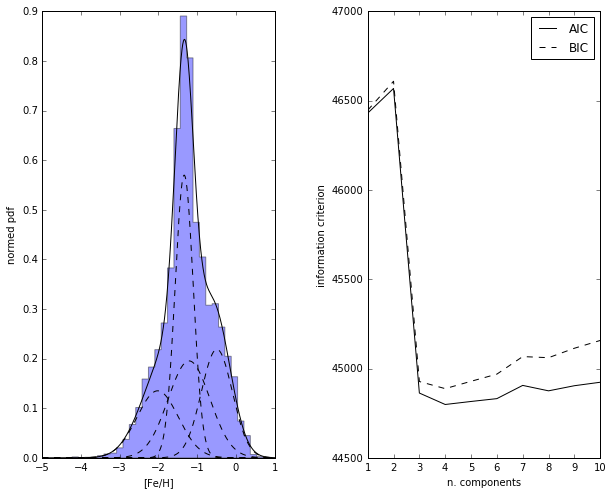

In [11]:
# gaussian mixture models (halo star [Fe/H] distribution)
rgc, feh, dist, afe = np.loadtxt('kgsp.sgr', usecols=(6, 11, 23, 27), unpack=True)
feh = np.array([[f] for f in feh])

# fit models with 1-10 components
N = np.arange(1, 11)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GMM(N[i], covariance_type='full', n_iter=10000).fit(feh)

# compute the AIC and the BIC
AIC = [m.aic(feh) for m in models]
BIC = [m.bic(feh) for m in models]

# choose the model with the lowest AIC
gmm = models[np.argmin(AIC)]

# and plot (see http://www.astroml.org/book_figures/chapter4/fig_GMM_1D.html)
fig = plt.figure()
fig.subplots_adjust(wspace=0.4)

ax = fig.add_subplot(121)
ax.hist(feh, 30, normed=True, histtype='stepfilled', alpha=0.4)
# make values to test against the models (make an empirical pdf)
test = np.array([[t] for t in np.linspace(-5, 1, 1000)])
logprob, responsibilities = gmm.score_samples(test)
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]
ax.plot(test, pdf, '-k')
ax.plot(test, pdf_individual, '--k')
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('normed pdf')

ax = fig.add_subplot(122)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, '--k', label='BIC')
ax.set_xlabel('n. components')
ax.set_ylabel('information criterion')
ax.legend(loc=1)